In [63]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import numpy as np
from random import randint
import json

plt.style.use(["Solarize_Light2"])
plt.rcParams["axes.edgecolor"] = "#66818c"
plt.rcParams["axes.facecolor"] = "#263238"
plt.rcParams["figure.facecolor"] = "#263238"
plt.rcParams["grid.color"] = "#3f575b"
plt.rcParams["xtick.color"] = "#bfd5dd"
plt.rcParams["ytick.color"] = "#bfd5dd"
plt.rcParams["text.color"] = "#bfd5dd"
plt.rcParams["axes.labelcolor"] = "#bfd5dd"

engine = create_engine("postgresql+psycopg2://{}:{}@{}:{}/{}".format("postgres",
                                                                     "123",
                                                                     "172.17.0.2",
                                                                     "5432",
                                                                     "estimator"))
table_name = "building"

In [64]:
stations = []
with open("../../data/mos_metro.json") as file:
    metro = json.loads(file.read())
    for line in metro["lines"]:
        for station in line["stations"]:
            stations.append({
                "name": station["name"],
                "line": line["name"],
                "lat": station["lat"],
                "lng": station["lng"]
            })
    stations = pd.DataFrame(stations)
    stations = stations[~stations.lng.isin([55.708831, 40.976995, 55.776667])]
query = """ SELECT lat,
                   lng
            FROM {}
            WHERE district > -1
        """.format(table_name)
df = pd.read_sql(query, engine)

In [65]:
query = """ SELECT area,
                   area_kitchen,
                   area_living,
                   price
            FROM flat
        """
df = pd.read_sql(query, engine)
df.loc[:, "ppm"] = df.price / df.area
df = df[(df.area_kitchen < 4e+1)]
df.drop("price", axis=True, inplace=True)

df = df[~df.area_living.isnull()]
df = (df-df.min())/(df.max()-df.min())
X = df.drop("area_kitchen", axis=True).values
y = df["area_kitchen"].values

epoch = 40000
step = .005
w = [0] * X.shape[1]
for _ in range(epoch):
    i = randint(0, X.shape[0]-1)
    w -= step * 2 * (X[i].dot(w)-y[i]) * X[i]

query = """ SELECT area,
                   price,
                   street
            FROM flat
            INNER JOIN building ON building_id = building.id
        """
df = pd.read_sql(query, engine)
df.loc[:, "ppm"] = df.price / df.area
df = df.groupby("street").ppm.mean()
streets = df[df > 4e+05].index

table_name = "flat"
query = """ SELECT owner_type,
                   area,
                   area_kitchen,
                   area_living,
                   floor,
                   rooms,
                   layout,
                   height,
                   bathrooms,
                   window_types,
                   balconies,
                   condition,
                   price,
                   type,
                   year,
                   material,
                   floors,
                   garbage_chute,
                   heating_type,
                   district,
                   lng,
                   lat,
                   street
            FROM {}
            INNER JOIN building ON flat.building_id = building.id
            WHERE district > -1
        """.format(table_name)
df = pd.read_sql(query, engine)
df.loc[:, "ppm"] = df.price / df.area
df.drop("price", axis=True, inplace=True)
df.loc[:, "window_0"] = df.window_types.apply(lambda i: None if i is None else i[0])
df.loc[:, "window_1"] = df.window_types.apply(lambda i: None if i is None else i[1])
df[["window_1", "window_0"]] = df[["window_1", "window_0"]].fillna(0)
df.drop("window_types", axis=True, inplace=True)
df.loc[:, "bathrooms_0"] = df.bathrooms.apply(lambda i: None if i is None else i[0])
df.loc[:, "bathrooms_1"] = df.bathrooms.apply(lambda i: None if i is None else i[1])
df[["bathrooms_0", "bathrooms_1"]] = df[["bathrooms_0", "bathrooms_1"]].fillna(0)
df.drop("bathrooms", axis=True, inplace=True)
df.loc[:, "balconies_0"] = df.balconies.apply(lambda i: None if i is None else i[0])
df.loc[:, "balconies_1"] = df.balconies.apply(lambda i: None if i is None else i[1])
df[["balconies_0", "balconies_1"]] = df[["balconies_0", "balconies_1"]].fillna(0)
df.drop("balconies", axis=True, inplace=True)
df.loc[~df.garbage_chute.isnull() & df.garbage_chute, "garbage_chute_1"] = 1
df.loc[~df.garbage_chute.isnull() & df.garbage_chute == False, "garbage_chute_0"] = 1
df.loc[:, "garbage_chute_0"] = df.loc[:, "garbage_chute_0"].fillna(0)
df.loc[:, "garbage_chute_1"] = df.loc[:, "garbage_chute_1"].fillna(0)
df.drop("garbage_chute", axis=True, inplace=True)
for i in df.type.unique():
    if i >= .0:
        df.loc[df.type == i, "type_"+str(i)] = 1
        df.loc[:, "type_"+str(i)] = df.loc[:, "type_"+str(i)].fillna(0)
df.drop("type", axis=True, inplace=True)
for i in df.layout.unique():
    if i >= .0:
        df.loc[df.layout == i, "layout_"+str(i)] = 1
        df.loc[:, "layout_"+str(i)] = df.loc[:, "layout_"+str(i)].fillna(0)
df.drop("layout", axis=True, inplace=True)
for i in df.material.unique():
    if i >= .0:
        df.loc[df.material == i, "material_"+str(i)] = 1
        df.loc[:, "material_"+str(i)] = df.loc[:, "material_"+str(i)].fillna(0)
df.drop("material", axis=True, inplace=True)
for i in df.condition.unique():
    if i >= .0:
        df.loc[df.condition == i, "condition_"+str(i)] = 1
        df.loc[:, "condition_"+str(i)] = df.loc[:, "condition_"+str(i)].fillna(0)
df.drop("condition", axis=True, inplace=True)
for i in df.heating_type.unique():
    if i >= .0:
        df.loc[df.heating_type == i, "heating_type_"+str(i)] = 1
        df.loc[:, "heating_type_"+str(i)] = df.loc[:, "heating_type_"+str(i)].fillna(0)
df.drop("heating_type", axis=True, inplace=True)
for i in df.owner_type.unique():
    if i >= .0:
        df.loc[df.owner_type == i, "owner_type_"+str(i)] = 1
        df.loc[:, "owner_type_"+str(i)] = df.loc[:, "owner_type_"+str(i)].fillna(0)
df.drop("owner_type", axis=True, inplace=True)

for i in df.district.unique():
    if i >= .0:
        df.loc[df.district == i, "district_"+str(i)] = 1
        df.loc[:, "district_"+str(i)] = df.loc[:, "district_"+str(i)].fillna(0)
df.drop("district", axis=True, inplace=True)
df.loc[:, "l1"] = df.street.isin(streets)
df.drop("street", axis=True, inplace=True)
for i in df.loc[df.area_kitchen.isnull() & ~df.area_living.isnull()].index:
    X = df.loc[i, ["area", "area_living", "ppm"]]
    X = ((X-X.min())/(X.max()-X.min())).values
    a = X.dot(w)
    if a > df.loc[:, "area_kitchen"].mean():
        df.loc[i, "area_kitchen"] = a - df.loc[:, "area_kitchen"].std()
    else:
        df.loc[i, "area_kitchen"] = a + df.loc[:, "area_kitchen"].std()
for x in [x for x in df.columns if "material_" in x]:
    m = df[df[x] == 1].height.median()
    df.loc[df[x] == 1, "height"] = df.loc[df[x] == 1, "height"].fillna(m)
df = df[(df.ppm >= 80000) & (df.ppm < 1000000) & (df.height > 2.4) & (df.height < 4.9) & ~df.area_kitchen.isnull() & ~df.area_living.isnull() & (df.floor!=69) & (df.year > 1000)]
df.loc[:, "floorgr17"] = (df.floor < 17) & (df.floor != 50) & (df.floor != 55)
df.floorgr17 = df.floorgr17.astype(int)
df.loc[:, "byless1944"] = df.year < 1944
df.byless1944 = df.byless1944.astype(int)
df.loc[:, "ff"] = df.floors / df.floor
df.loc[:, "aa"] = df.area > 1.5*df.area.mean()
df.loc[:, "aa2"] = df.area_living > df.area_living.mean()
df.loc[:, "aa3"] = df.floors > .5*df.floors.median()
df.loc[:, "aa4"] = df.height > 1.4*df.height.mean()
df.loc[:, "aa5"] = df.bathrooms_0 > df.bathrooms_0.mean()
df.loc[:, "aa6"] = df.bathrooms_1 > df.bathrooms_1.mean()
df.loc[:, "aa7"] = (df.bathrooms_0 + df.bathrooms_1) > (df.bathrooms_0 + df.bathrooms_1).mean()
df.loc[:, "aa8"] = df.rooms > df.rooms.median()
df.loc[:, "aa9"] = df.area_kitchen//10 == 0
df.loc[:, "aa10"] = df.floor//10 == 0
df.loc[:, "aa11"] = df.floors//10 > 1
df.loc[:, "d1"] = ((df.lng - 37.59565428999999)**2 + (df.lat-55.74813359000001)**2)**.5
df.loc[:, "d2"] = df.d1 < .1
df.shape

(21895, 72)

In [66]:
locations = df.set_index(["lat", "lng"]).index.unique()
df_l = df.set_index(["lat", "lng"])

In [67]:
distances = {}
for i, (lat, lng) in enumerate(locations):
    distances[(lat, lng)] = dict()
    for _, station in stations.iterrows():
        distances[(lat, lng)][station["name"]] = ((station.lng-lng)**2+(station.lat-lat)**2)**.5
df_l.loc[:, "distances"] = pd.Series(distances)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2855: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


In [71]:
cost = lambda y_, y: 1/len(y) * sum((y_-y)**2)

In [72]:
columns = [
#     'layout_0.0',
#     'heating_type_1.0',
#     'condition_2.0',
#     'material_7.0',
#     'material_1.0',
#     'layout_2.0',
#     'layout_1.0',
#     'balconies_1',
#     'window_0',
#     'year',
#     'window_1',
#     'balconies_0',
#     'owner_type_0.0',
#     'heating_type_0.0',
#     'heating_type_2.0',
#     'floors',
#     'material_4.0',
#     'garbage_chute_1',
#     'garbage_chute_0',
#     'heating_type_3.0',
#     'owner_type_2.0',
#     'condition_0.0',
#     'material_0.0',
#     'type_1.0',
#     'owner_type_1.0',
#     'type_0.0',
#     'floor',
#     'material_2.0',
#     'owner_type_3.0',
#     'bathrooms_1',
#     'condition_1.0',
#     'material_6.0',
#     'rooms',
#     'material_3.0',
#     'area_kitchen',
#     'bathrooms_0',
#     'condition_3.0',
#     'area_living',
#     'area',
#     'height',
    'ppm',
    'distances',
#     'lng',
#     'lat',
#     'dist_1',
#     'dist_2',
#     'dist_3',
#     'dist_5',
#     'dist_8',
#     'dist_13',
#     'dist_21',
    
]
X = df_l.drop(columns, axis=True)
y = df_l.ppm
X = ((X-X.mean())/X.std()).values
y = ((y-y.mean())/y.std()).values
# X = ((X-X.min())/(X.max()-X.min())).values
# y = ((y-y.min())/(y.max()-y.min())).values

epoch = 90000
step = 100
w = [0] * X.shape[1]
errs = []
for e in range(epoch):
    s = X.shape[0]
    i = randint(0, s-1)
    w -= (step/(s+100*e) * (X[i].dot(w)-y[i])) * (X[i] + np.linalg.norm(w)**.5)
    errs.append(cost(X[0:100].dot(w), y[0:100]))
w

array([ 0.05774783,  0.0223991 ,  0.01976926,  0.06013699, -0.05938881,
        0.10845235,  0.08182069, -0.04419687, -0.01551066, -0.01071022,
        0.00500547, -0.0130015 , -0.00648829, -0.03473181,  0.05270674,
        0.03933095,  0.06402835,  0.02776231, -0.02014264,  0.00655409,
       -0.00587952,  0.03116851,  0.03817423,  0.00769308,  0.02179358,
        0.03804052, -0.0039361 ,  0.0040304 ,  0.01234885,  0.11649452,
        0.02851338,  0.07453582, -0.03415581,  0.02835106,  0.00713915,
        0.00290955, -0.00456535, -0.02149064, -0.01211498, -0.01461823,
        0.16558359, -0.04491035,  0.00154087,  0.0394536 ,  0.02622939,
        0.07151544,  0.07158619,  0.01007318,  0.10416407,  0.0392064 ,
       -0.00680863,  0.03376329,  0.4056629 , -0.00240367, -0.0379663 ,
       -0.04021638,  0.09277022,  0.01290374,  0.01290433, -0.03195841,
       -0.00712928, -0.02410461,  0.00792856, -0.03693559,  0.0318126 ,
        0.02750218, -0.0091055 , -0.17537323,  0.11694835])

In [73]:
sum((X.dot(w)-y)**2)/len(y)

0.2632253330408432

In [74]:
y_error_rub = X.dot(w) * df_l.ppm.std() + df_l.ppm.mean() - df_l.ppm

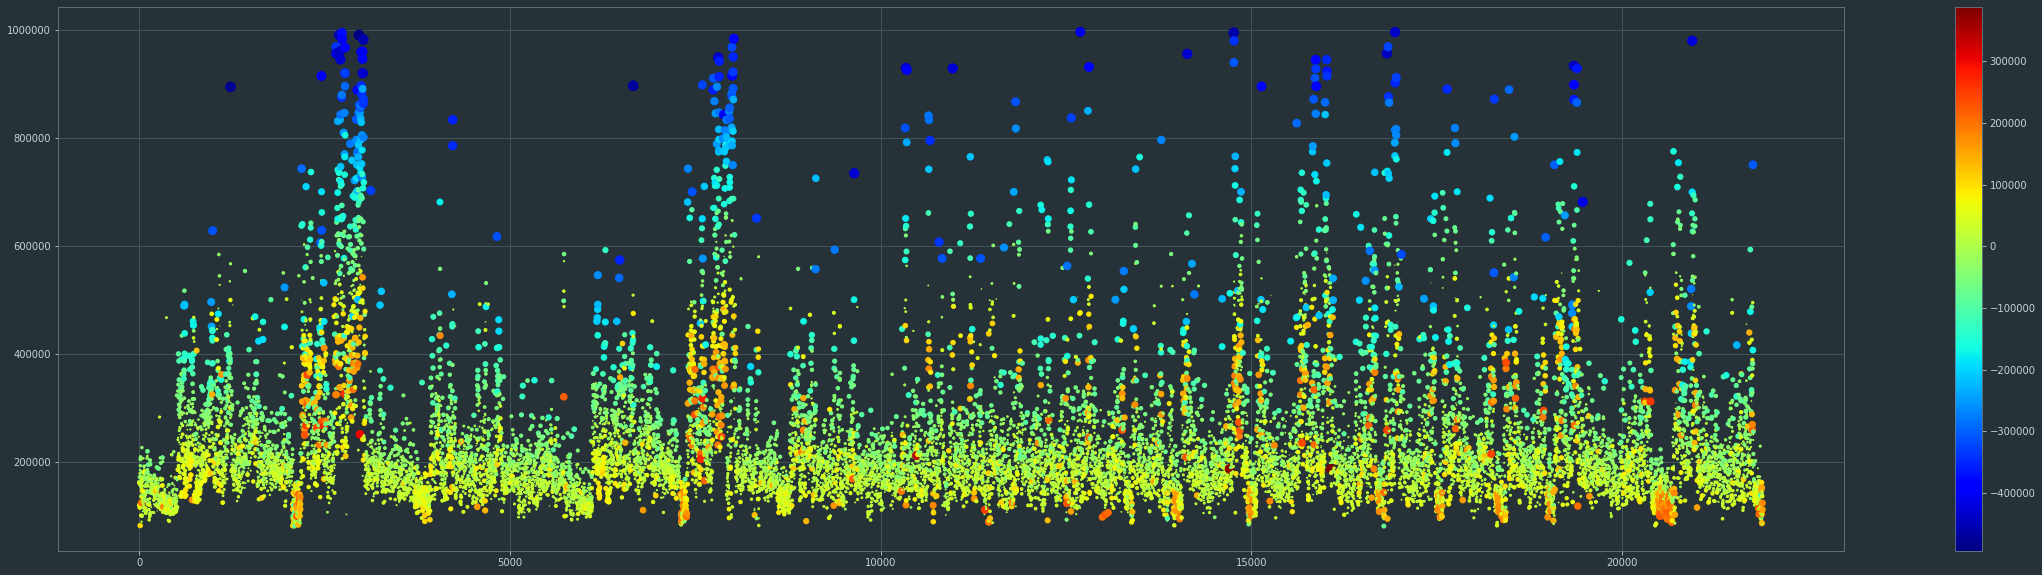

In [75]:
plt.figure(figsize=(40, 10))
plt.scatter(range(len(y)), df_l.ppm, alpha=1, c=y_error_rub, s=((y_error_rub**2)**.5)/5000, cmap="jet")
plt.colorbar();

(21895, 13992)

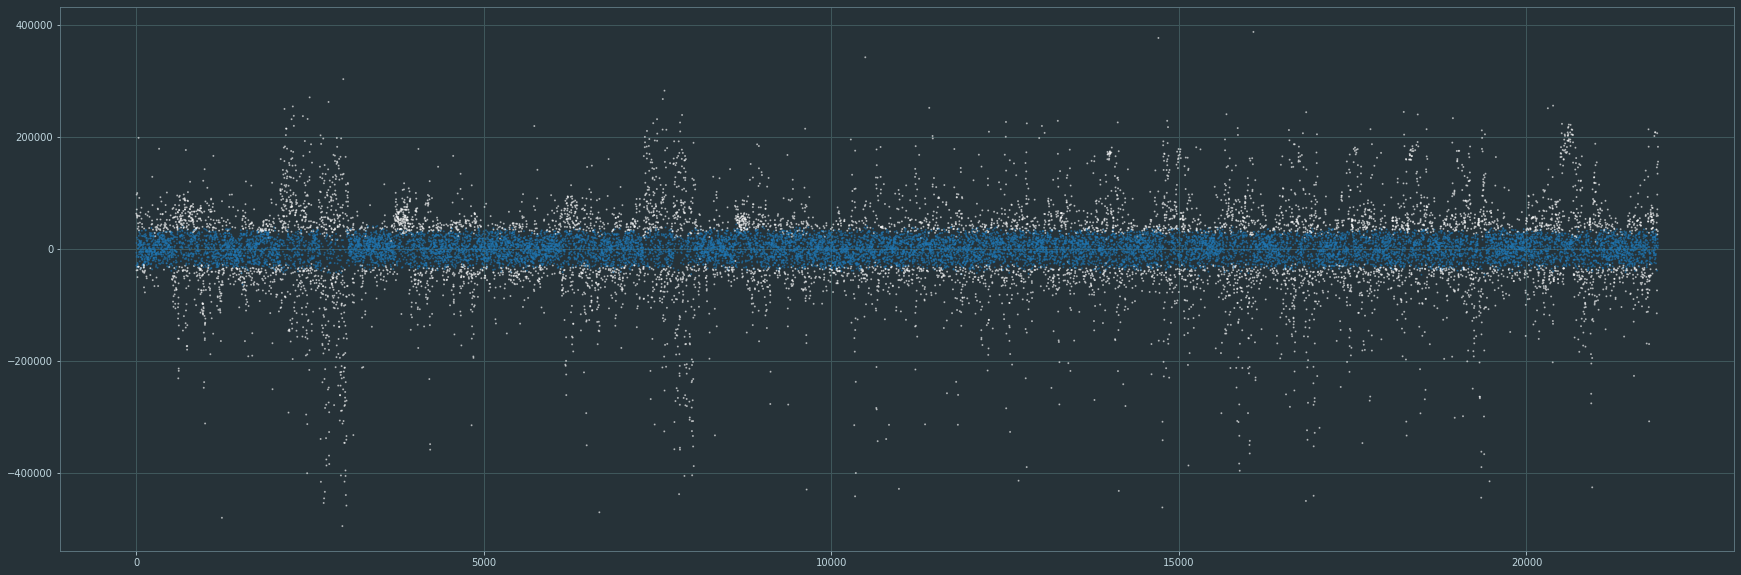

In [76]:
plt.figure(figsize=(30, 10))
plt.scatter(range(len(y)), y_error_rub, alpha=.5, s=1, c=["#1f77b4" if c > -32500 and c < 32500 else "w" for c in y_])
len(y), len([ i for i in y_error_rub.values if i > -32500 and i < 32500 ])

In [82]:
np.std((y_error_rub**2)**.5), np.median((y_error_rub**2)**.5), np.mean((y_error_rub**2)**.5)

(45921.081092111344, 22706.939469776553, 36561.719641994336)

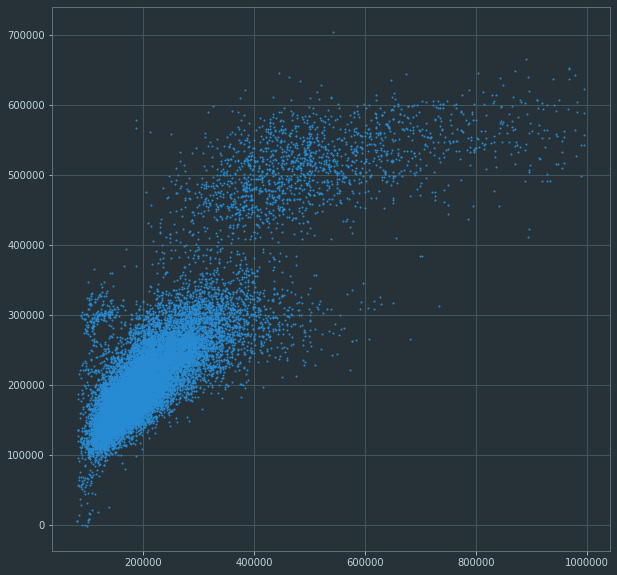

In [78]:
plt.figure(figsize=(10, 10))
plt.scatter(df_l.ppm, y_+df_l.ppm, s=1);